
<font size = "5"> **Day 1: [Atomic Resolution STEM and Machine Learning](../MLSTEM2024.ipynb)** </font>


<hr style="height:1px;border-top:4px solid #FF8200" />

[Download](https://raw.githubusercontent.com/ahoust17/MLSTEM2024/main/Day1/Generate_Dataset.ipynb)

[![OpenInColab](https://colab.research.google.com/assets/colab-badge.svg)](
    https://colab.research.google.com/github/gduscher/MLSTEM2024/blob/main/Day1/Generate_Dataset.ipynb)

# Making a Dataset for Training a Segmentation Model to Distinguish Atoms

**Speaker: Austin Houston**

part of the workshop of 

<font size = "5"> **[Machine Learning in Transmission Electron Microscopy](../_MLSTEM.ipynb)**</font>

<table style="margin-right:auto;margin-left:0px">
  <tr>
    <td>Gerd Duscher </td>
    <td>Sergei Kalinin</td>
  </tr>
  <tr>
    <td colspan="2"><center>Microscopy Facilities</td> 
  </tr>
  
  <tr>
    <td colspan="2"><center>Materials Science & Engineering</td>
  </tr>
  <tr>
    <td colspan="2"><center>Institute of Advanced Materials & Manufacturing</td>
  </tr>
  <tr>
    <td colspan="2"><center> The University of Tennessee, Knoxville</center> </td>
  </tr>
</table>
        
**June 2024**

## Load packages

In [ ]:
import sys
import importlib.metadata
def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = importlib.metadata.version(package_name)
    except importlib.metadata.PackageNotFoundError:
        version = '-1'
    return version

if test_package('pyTEMlib') < '0.2024.4.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
print('done')

print('installing DataGenSTEM')
!git clone https://github.com/ahoust17/DataGenSTEM.git
print('done')

import numpy as np
import matplotlib.pyplot as plt
import secrets
from ase.io import read
from ase.visualize import view
from sklearn.model_selection import train_test_split

import pyTEMlib.file_tools as ft
import pyTEMlib.image_tools 
import pyTEMlib.probe_tools
import pyTEMlib.atom_tools

sys.path.append('./DataGenSTEM/DataGenSTEM')
import data_generator as dg

# Why Use Machine Learning?

### - Accuracy and Robustness
### - Low Signal-to-Noise Conditions
### - Multi-Class Segmentation
### - Where Atoms Overlap


### Read in the experimental data


In [ ]:
!wget https://github.com/gduscher/MLSTEM2024/blob/main/example_data/STO_Stack_10.dm3
path = './STO_Stack_10.dm3'

dset = ft.open_file(path)
image_stack = dset['Channel_000']

# normalization
image_stack -= np.min(image_stack)
image_stack /= np.max(image_stack)

view = image_stack.plot()
print('Shape:', image_stack.shape)

pixel_size = image_stack.original_metadata['BinaryResult']['PixelSize']['width']*10^10 # 'Angstrom/pixel'
print('Pixel size:', pixel_size, 'Angstrom/pixel')

## Main Idea: Simulated Data Must be Reasonably Similar to Experimental Data

In [ ]:
fig, ax = plt.subplots(1, 1)
ax.hist(image_stack.flatten(), bins=256, range=[0, 1], density=True)
ax.set_xlabel('Normalized intensity')
fig.suptitle('Distribution of pixel values')

## Read in crystal structure

In [2]:
xtal = read('./DataGenSTEM/crystal_files/SrTiO3.cif') * (50,50,1)
# view(xtal, viewer='x3d')

## Define image bounds

In [3]:
# Define the image size in Angstroms
positions = xtal.get_positions()[:, :2]
xmin, xmax = np.min(positions[:, 0]), np.max(positions[:, 0])
ymin, ymax = np.min(positions[:, 1]), np.max(positions[:, 1])
borders = 1
axis_extent = (xmin - borders, xmax + borders, ymin - borders, ymax + borders)
pixel_size = pixel_size # Angstrom/pixel

### Make xtal (with random rotations and vacancies)

In [5]:
rotation = 0
phonon_sigma = 0.10
n_vacancies = 10

rot_xtal = dg.get_imaging_xtal(xtal = xtal, 
                              n_cells = (1,1,1), 
                              rotation = rotation, 
                              n_vacancies = n_vacancies, 
                              phonon_sigma = phonon_sigma, 
                              axis_extent = axis_extent)
# view(rot_xtal, viewer='x3d')

### Make scattering potential - sum of gaussians

In [6]:
potential = dg.get_pseudo_potential(xtal = rot_xtal,
                                    pixel_size = pixel_size,
                                    sigma = 0.1,
                                    axis_extent = axis_extent,
                                    mode = 'gaussian')

fig, ax = plt.subplots(1, 1)
ax.imshow(potential, cmap='jet', vmin=0, vmax=0.5)
ax.axis('off')

### Simulate the beam - approximately
The shape of a beam which evenly illuminates a round apperture, due to diffraction, is an airy disk.

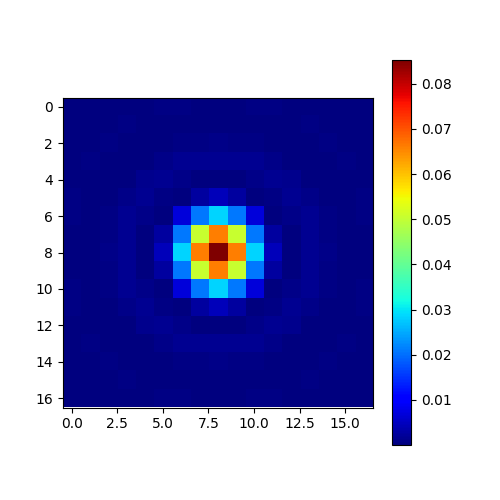

In [8]:
psf = dg.get_point_spread_function(airy_disk_radius = 1, size = 8)

fig, ax = plt.subplots(1, 1)
ax.imshow(psf, cmap='jet')
fig.colorbar(ax.imshow(psf, cmap='jet'), ax=ax)

### Case-specific for STO
The overlapping atoms complicate the categories of the labels

In [9]:
# Delete Oxygen Atoms
to_delete = []
for atom in rot_xtal:
    if atom.symbol == 'O':
        to_delete.append(atom.index)

mask_xtal = rot_xtal.copy()
del mask_xtal[to_delete]

### Make image, add shot noise, and make masks

In [10]:
# Image = Potential X PSF
perfect_image = dg.convolve_kernel(potential, psf)

# Add sampling noise (0 to 1)
count_statistics = 0.8
noisy_image = dg.add_poisson_noise(perfect_image, shot_noise = count_statistics)

# Generate label masks - ground truths for training
masks = dg.get_masks(mask_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 8, mode='integer')

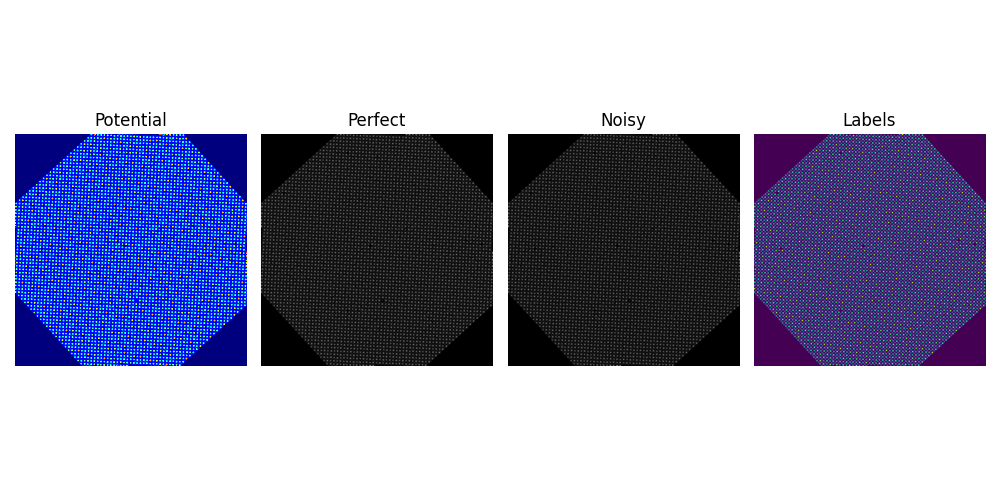

In [11]:
fig, ax = plt.subplots(1, 4, sharex=True, sharey=True, figsize=(10, 5))

ax[0].set_title('Potential')
ax[0].imshow(potential, cmap='jet', vmax=0.5)

ax[1].set_title('Perfect Image')
ax[1].imshow(perfect_image, cmap='gray')

ax[2].set_title('Noisy Image')
ax[2].imshow(noisy_image, cmap='gray')

ax[3].set_title('Labels')
ax[3].imshow(masks, cmap='viridis')

for ax in ax:
    ax.axis('off')
fig.tight_layout()


### Create a dataset by randomly cropping and magnifying the images and masks

In [12]:
# Crop and zoom
n_crops = 5
crop_size = 256
magnification_var = 0.3

batch_ims = dg.shotgun_crop(noisy_image, crop_size = crop_size, n_crops = n_crops, seed = 42, magnification_var = magnification_var, roi = 'middle')
batch_ims = batch_ims.reshape(-1,crop_size,crop_size)
print('Image shape:', batch_ims.shape)

batch_masks = dg.shotgun_crop(masks, crop_size = crop_size, n_crops = n_crops, seed = 42, magnification_var = magnification_var, return_binary = True, roi = 'middle')
print('Mask shape:', batch_masks.shape)


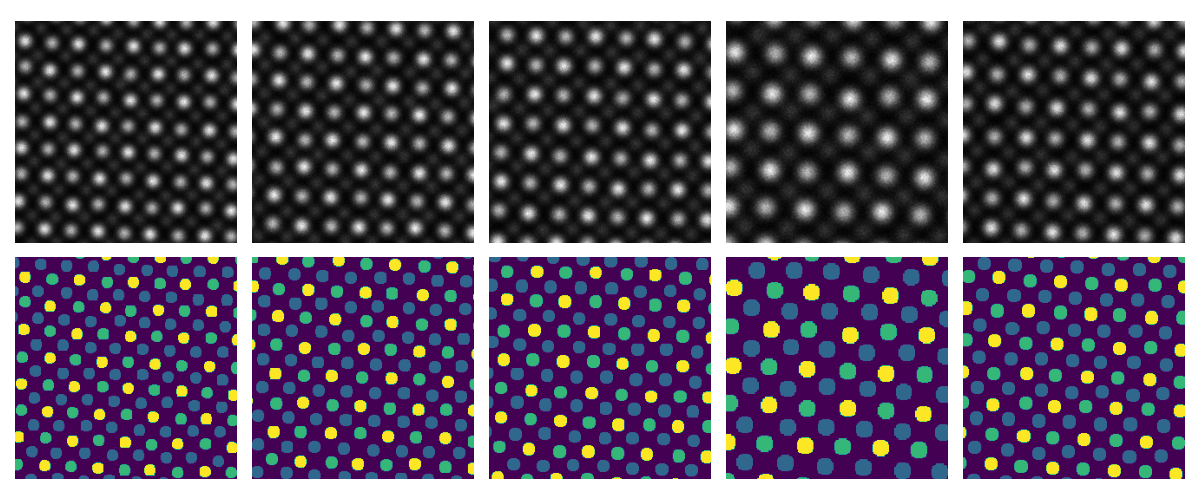

In [13]:
fig, axs = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(12, 5))

for i, ax in enumerate(axs[0,:]):
    ax.imshow(batch_ims[i], cmap='gray')
    ax.axis('off')
for i, ax in enumerate(axs[1,:]):
    ax.imshow(batch_masks[i], cmap='viridis')
    ax.axis('off')

fig.tight_layout()


### Now we put it all together!

In [14]:
# Generate training dataset
n_images = 100
crop_size = 256
pixel_size = pixel_size # Angstrom/pixel
n_crops = 20 # per image

print('reading xtal:')
xtal = read('./cif_files/SrTiO3.cif') * (50,50,1)
positions = xtal.get_positions()[:, :2]
xmin, xmax = np.min(positions[:, 0]), np.max(positions[:, 0])
ymin, ymax = np.min(positions[:, 1]), np.max(positions[:, 1])
borders = 1
axis_extent = (xmin - borders, xmax + borders, ymin - borders, ymax + borders)


image_counter = 0
master_images = np.zeros((n_images, crop_size, crop_size))
master_labels = np.zeros((n_images, crop_size, crop_size))

print('making images:')
while image_counter < n_images:
    master_seed = secrets.randbits(128)
    rng = np.random.default_rng(master_seed)

    # Set random params
    # --------------------------------------------------
    phonon_sigma = rng.uniform(0.05, 0.10)
    rotation = rng.uniform(-2, 2)
    atom_var = rng.normal(loc = 0.175, scale = 0.01)
    airy_disk_size = 1
    shot_noise = rng.uniform(0.6, 0.9)
    magnification_var = rng.uniform(0.2, 0.35)
    crop_param_seed = rng.integers(0, 1000000)
    # --------------------------------------------------

    rot_xtal = dg.get_xtal_matrix(xtal = xtal, 
                                n_cells = (1,1,1), 
                                rotation = rotation, 
                                n_vacancies = 10, 
                                phonon_sigma = phonon_sigma, 
                                axis_extent = axis_extent)

    potential = dg.get_pseudo_potential(xtal = rot_xtal,
                                        pixel_size = pixel_size,
                                        sigma = atom_var,
                                        axis_extent = axis_extent)
    potential /= np.max(potential)

    psf = dg.get_point_spread_function(airy_disk_radius = airy_disk_size, size = 8)

    # Delete any Oxygen that shares XY-projection within a cutoff distance with any Titanium
    to_delete = []
    cutoff = 1
    all_positions = rot_xtal.get_positions()
    all_symbols = rot_xtal.get_chemical_symbols()
    Ti_indices = [idx for idx, symbol in enumerate(all_symbols) if symbol == 'Ti']
    O_indices = [idx for idx, symbol in enumerate(all_symbols) if symbol == 'O']
    Ti_pos = all_positions[Ti_indices]
    O_pos = all_positions[O_indices]
    for o_idx, o_pos in zip(O_indices, O_pos):
        min_distance = np.linalg.norm(Ti_pos[:, :2] - o_pos[:2], axis=1).min()
        if min_distance < cutoff:
            to_delete.append(o_idx)  
    mask_xtal = rot_xtal.copy()
    del mask_xtal[to_delete]

    perfect_image = dg.convolve_kernel(potential, psf)
    noisy_image = dg.add_poisson_noise(perfect_image, shot_noise = shot_noise)
    masks = dg.get_masks(mask_xtal, axis_extent = axis_extent, pixel_size = pixel_size, radius = 8, mode='integer')

    batch_ims = dg.shotgun_crop(noisy_image, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, roi = 'middle')
    batch_ims = batch_ims.reshape(-1,crop_size,crop_size)
    batch_masks = dg.shotgun_crop(masks, crop_size = crop_size, n_crops = n_crops, seed = crop_param_seed, magnification_var = magnification_var, return_binary = True, roi = 'middle')

    # Process batch images and masks
    for i, (image, mask) in enumerate(zip(batch_ims, batch_masks)):
        image = image - np.min(image)
        image = image / np.max(image)
        master_images[image_counter] = image
        master_labels[image_counter] = mask
        image_counter += 1
        print(f'Image {image_counter}/{n_images}', end='\r')

print('done!')
X_train, X_test, y_train, y_test = train_test_split(master_images, master_labels, test_size=0.2, random_state=42)
np.savez('training_data.npz', X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test)

reading xtal:
making images:
done! 100/100
